In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
import warnings

from src import data

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-04-13


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False

# True for 50 ms version, 200 ms version otherwise
FTRACT_SHORT = False

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

## Load data

### Load F-TRACT data

In [3]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION,short=FTRACT_SHORT)

if PARCELLATION == "DKT":
    for a in [0,1]:
        response_probability = np.delete(response_probability,ids_to_delete_in_dkt,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete_in_dkt,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete_in_dkt,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete_in_dkt,axis=a)

mask = np.logical_and(n_stim > 100, n_impl > 5)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    mask_amp = mask
else:
    mask_amp = (n_stim*response_probability)>=100

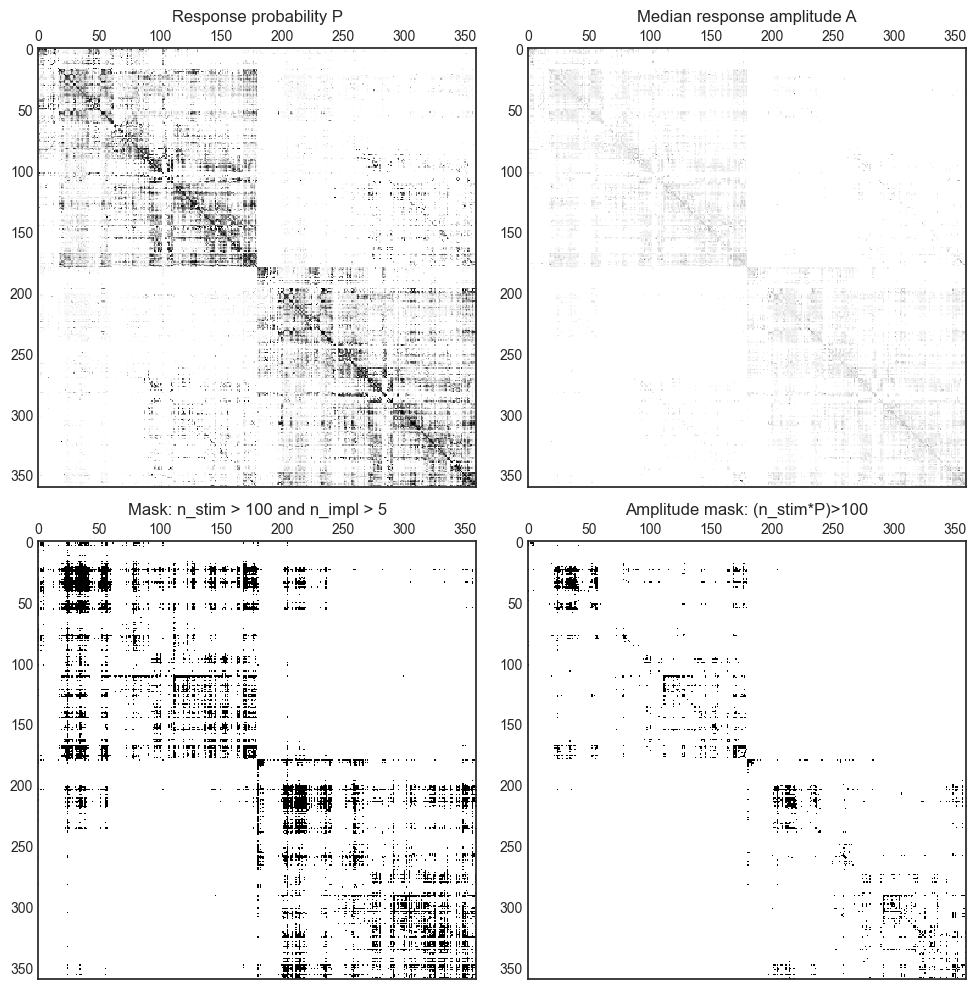

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(np.log(response_amplitude))
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    axs[1,1].set_title("Amplitude mask same as mask")
else:
    axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

### Load structural connectivity data

In [5]:
SC_matrices = []

if PARCELLATION == "DKT":
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ftract_labels,ids_to_delete_in_dkt)
    ED = None

elif PARCELLATION == "MNI-HCP-MMP1":
    ED = data.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ftract_labels,ED)

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:325: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_rh",SC_W_M, SC_L_M,np.log(SC_W_M)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:328: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_simple",SC_W_M_mean, SC_L_M_mean,np.log(SC_W_M_mean)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:332: RuntimeWarning: divide by zero encountered in log
  SC_matrices_mica.append(("Mica-Mics_dist",SC_W_M_dist, SC_L_M_dist,np.log(SC_W_M_dist)))


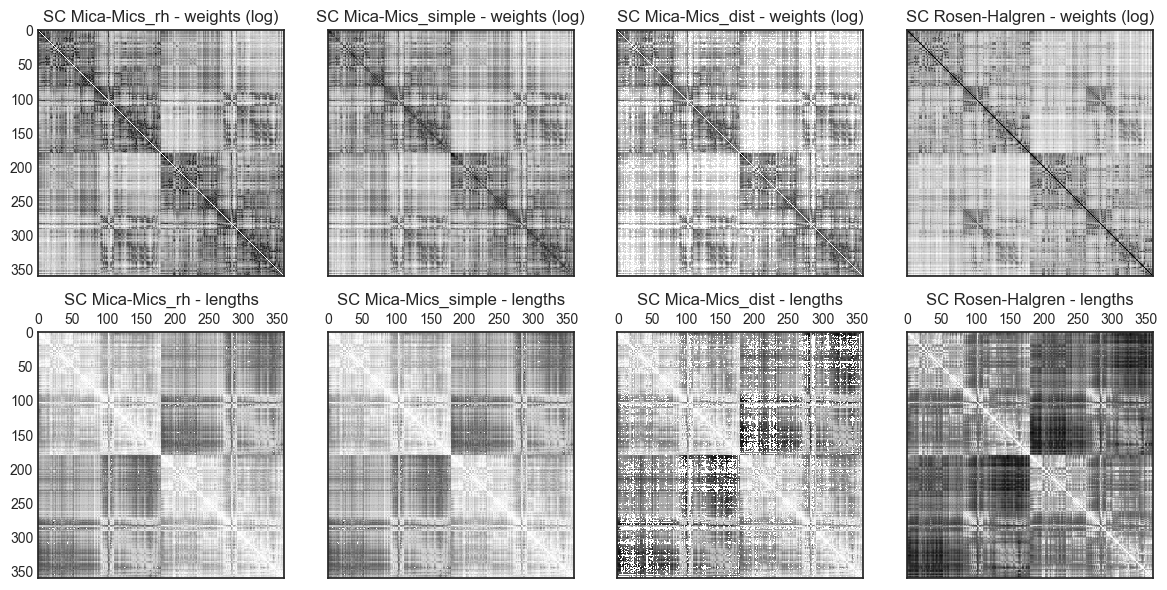

In [6]:
plt.rcParams['figure.figsize'] = [3*number_of_SC,6]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")

    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

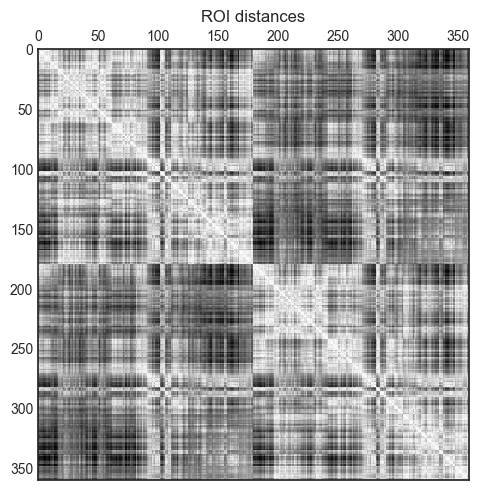

In [7]:
if ED is not None:
    plt.rcParams['figure.figsize'] = [5,5]
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.matshow(ED)
    axs.set_title("ROI distances")

## Correlations

In [8]:
def calculate_communicatin_metrics(ED,SC_L,SC_W):
    metrics_dict = dict()

    if ED is not None:
        metrics_dict["ED"] = ED
    metrics_dict["SC_W"] = SC_W
    #df["SC_W_log"] = SC_W_log[mask].flatten()

    
    if SC_L is not None:
        metrics_dict["SC_L"] = SC_L
        shortest_paths,_ = metrics.distance_wei_floyd(SC_L)
        metrics_dict["shortest_path_eff"] = np.divide(1,shortest_paths)
    else:
        shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
        metrics_dict["shortest_path_eff_W"] = np.divide(1,shortest_paths)

    metrics_dict["communicability"] = metrics.communicability_wei(SC_W)

    
    if ED is not None:
        metrics_dict["search_information_ED"] = metrics.search_information(SC_W,ED)
    
    # FIXME
    #     _,_,nav_paths,_,_ = metrics.navigation_wu(ED, SC_W)
    #     metrics_dict["navigation_eff_ED"] = np.divide(1,nav_paths)
    
    if SC_L is not None: # second condition because it was complaining "ndarray is not C-contiguous"
        metrics_dict["search_information_SC_L"] = metrics.search_information(SC_W,SC_L)

    if SC_L is not None and ED is not None:
        _,_,_,_,nav_paths = metrics.navigation_wu(ED, SC_W)
        nav_paths = metrics.get_navigation_path_length(nav_paths, SC_L)
        metrics_dict["navigation_eff_SC_L"] = np.divide(1,nav_paths)

    _, metrics_dict["diffusion_eff"] = metrics.diffusion_efficiency(SC_W)

    return metrics_dict

def fill_df(df,mask,metrics_dict):

    for m in metrics_dict:
        matrix = metrics_dict[m]
        df[m] = matrix[mask].flatten()

In [9]:
stat_data = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:

    # this is necessary to supress warnings for some types of matrices
    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        metrics_dict = calculate_communicatin_metrics(ED,SC_L,SC_W)

    df_probability = pd.DataFrame({"response_probability":response_probability[mask].flatten()})
    df_amplitude = pd.DataFrame({"response_amplitude":response_amplitude[mask_amp].flatten()})

    fill_df(df_probability,mask,metrics_dict)
    fill_df(df_amplitude,mask_amp,metrics_dict)

    stat_data[name] = {"probability":df_probability,"amplitude":df_amplitude}

In [10]:
def partial_corr_ED(d,x,method):
    result = []
    result.append(pd.DataFrame({"n":0,"r":0,"CI95%":[0,0],"p-val":0,"Y":"ED"})) # just to have fitting images

    for k in d.keys():
        if k == "ED" or k ==x:
            continue
        df_one_result = pg.partial_corr(data=d,x=x,y=k,covar="ED", method=method)
        df_one_result['Y'] = k
        result.append(df_one_result)
    
    return pd.concat(result)

In [11]:
keys = []

result_p = []
result_p_partial = []

result_a = []
result_a_partial = []

for name,_,_,_ in SC_matrices:
    keys.append(name)
    result_p.append(pg.pairwise_corr(stat_data[name]["probability"],columns=["response_probability"], method='spearman').round(3))
    result_a.append(pg.pairwise_corr(stat_data[name]["amplitude"],columns=["response_amplitude"], method='spearman').round(3))
    result_p_partial.append(partial_corr_ED(stat_data[name]["probability"],'response_probability',"spearman"))
    result_a_partial.append(partial_corr_ED(stat_data[name]["amplitude"],"response_amplitude","spearman"))

In [12]:
for r in result_p+result_a+result_p_partial+result_a_partial:
    r['r_abs'] = r['r'].apply(abs)
    #r['CI_size'] = r['CI95%'].apply(lambda x:(x[1]-x[0])/2)
for r in result_p+result_a:
    r['p_sigf'] = r['p-unc'].apply(lambda x: "*" if x< 0.05 else "")
for r in result_p_partial+result_a_partial:
    r['p_sigf'] = r['p-val'].apply(lambda x: "*" if x< 0.05 else "")

result_p = pd.concat(result_p, keys=keys).reset_index(names=["dataset","-"])
result_a = pd.concat(result_a, keys=keys).reset_index(names=["dataset","-"])
result_p_partial = pd.concat(result_p_partial, keys=keys).reset_index(names=["dataset","-"])
result_a_partial = pd.concat(result_a_partial, keys=keys).reset_index(names=["dataset","-"])

In [13]:
plt.style.use('ggplot')
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#E24A33', '#348ABD', '#8EBA42', '#777777','#FBC15E', '#FFB5B8', '#988ED5']) 

In [14]:
def plot_results(d,title):
    plt.figure(figsize=(7,7))
    

    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset")
    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    # if PARCELLATION == "MNI-HCP-MMP1":
    #     for n,container in zip(keys,ax.containers):
    #         ax.bar_label(container,labels=result_p[result_p["dataset"]==n]["p_sigf"])

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    plt.show()

def plot_results_overlay(d,d_partial,title):
    plt.figure(figsize=(7,7))

    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset", alpha=0.35,legend=False)

    sns.barplot(data=d_partial, x='Y', y='r_abs',hue="dataset",ax=ax)
    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    at = AnchoredText("opaque for partiall correlation\ninfluence of ED controlled",frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    # if PARCELLATION == "MNI-HCP-MMP1":
    #     for n,container in zip(keys,ax.containers):
    #         ax.bar_label(container,labels=result_p_partial[result_p_partial["dataset"]==n]["p_sigf"])

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    plt.show()

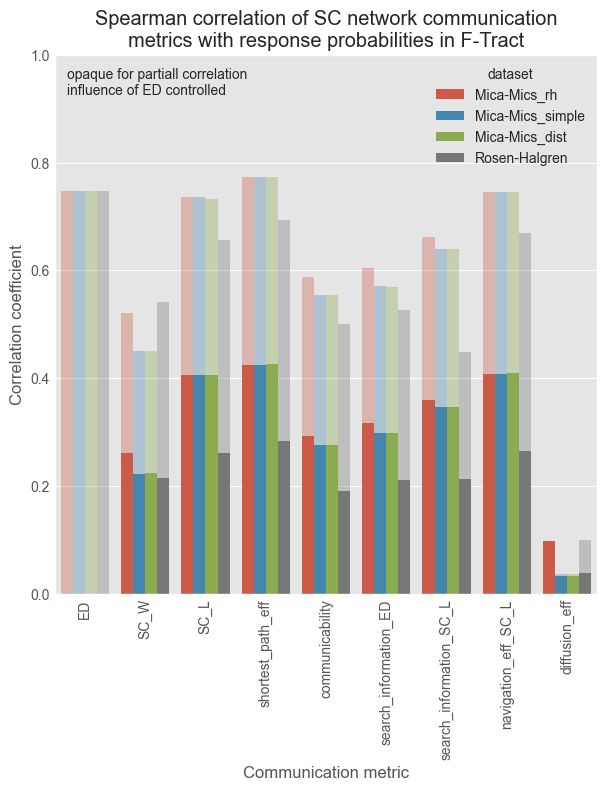

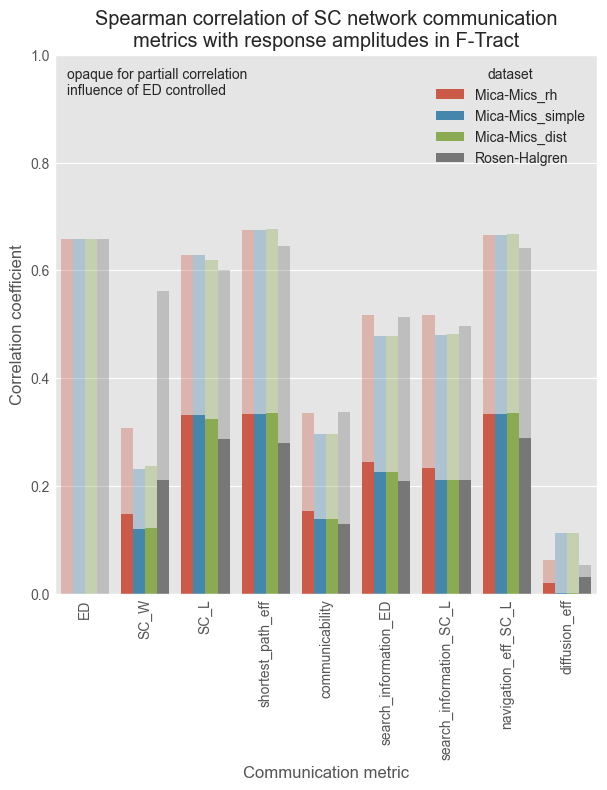

In [15]:
plot_results_overlay(result_p,result_p_partial,title="Spearman correlation of SC network communication\nmetrics with response probabilities in F-Tract")
plot_results_overlay(result_a,result_a_partial,title="Spearman correlation of SC network communication\nmetrics with response amplitudes in F-Tract")

In [16]:
# plot_results(result_p,title="Spearman correlation of SC network communication\nmetrics with response probability in F-Tract")
# plot_results(result_p_partial,title="Partial spearman correlation of SC network communication\nmetrics with response probability in F-Tract (ED controlled)")
# plot_results(result_a,title="Spearman correlation of SC network communication\nmetrics with response amplitude in F-Tract")
# plot_results(result_a_partial,title="Partial spearman correlation of SC network communication\nmetrics with response amplitude in F-Tract (ED controlled)")

In [17]:
np.where(mask,response_probability,np.nan).shape

(360, 360)

In [41]:
def df_per_roi(response,mask,metrics_dict,ftract_labels):

    masked_response = np.where(mask,response,np.nan)

    # apply mask to all matrices
    for m in metrics_dict:
        metrics_dict[m] = np.where(mask,metrics_dict[m],np.nan)

    temp = dict()
    for roi,label in enumerate(ftract_labels):
        df_per_roi = pd.DataFrame()
        response_per_roi = masked_response[roi,:]
        if np.isnan(response_per_roi).all():
            continue
        df_per_roi["response"] = pd.Series(response_per_roi)
        for m in metrics_dict:
            m_masked = metrics_dict[m]
            df_per_roi[m] = pd.Series(m_masked[roi,:])

        temp[label] = df_per_roi
    
    df = pd.concat(temp)
        
    return df

In [ ]:
stat_data_per_roi = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:

    # this is necessary to supress warnings for some types of matrices
    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        metrics_dict = calculate_communicatin_metrics(ED,SC_L,SC_W)

    df_probability = df_per_roi(response_probability,mask,metrics_dict,ftract_labels)
    df_amplitude = df_per_roi(response_amplitude,mask_amp,metrics_dict,ftract_labels)

    stat_data_per_roi[name] = {"probability":df_probability,"amplitude":df_amplitude}

In [65]:
stat_data_per_roi

{'Mica-Mics_rh': {'probability':           response         ED      SC_W      SC_L  shortest_path_eff  \
  L_V1 0       0.610   0.000000  0.000000       NaN                inf   
       1       0.665  32.704258  0.014810  30.00884           0.033324   
       2       0.502   4.387056  0.232363  17.99694           0.055565   
       3       0.342   9.158334  0.118516  24.83514           0.040266   
       4       0.559  20.061667  0.046179  26.94880           0.037107   
  ...            ...        ...       ...       ...                ...   
  R_PI 355       NaN        NaN       NaN       NaN                NaN   
       356       NaN        NaN       NaN       NaN                NaN   
       357       NaN        NaN       NaN       NaN                NaN   
       358       NaN        NaN       NaN       NaN                NaN   
       359       NaN        NaN       NaN       NaN                NaN   
  
            communicability  search_information_ED  search_information_SC_L  \

In [64]:
def corr_per_roi(df):
    r_per_roi = dict()
    for label in list(set(df.index.get_level_values(0))):
        relevant_df = df.xs(label, drop_level=False)

        # we need enoug non-zero values, otherwise the correlation does not make sense
        if relevant_df['response'].count() > 4:
            r_per_roi[label] = pg.pairwise_corr(relevant_df,'response', method='spearman').round(3)
    return pd.concat(r_per_roi)

In [66]:
keys = []

result_p_per_roi = []
result_p_partial_per_roi = []

result_a_per_roi = []
result_a_partial_per_roi = []

for name,_,_,_ in SC_matrices:
    print(name)
    keys.append(name)
    result_p_per_roi.append(corr_per_roi(stat_data_per_roi[name]["probability"]).round(3))
    #result_a_per_roi.append(corr_per_roi(stat_data[name]["amplitude"],columns=["response_amplitude"], method='spearman').round(3))
    #result_p_partial_per_roi.append(partial_corr_ED(stat_data[name]["probability"],'response_probability',"spearman"))
    #result_a_partial_per_roi.append(partial_corr_ED(stat_data[name]["amplitude"],"response_amplitude","spearman"))
print(result_p_per_roi)

Mica-Mics_rh
Mica-Mics_simple
Mica-Mics_dist


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")


Rosen-Halgren
[                X                        Y    method alternative   n      r  \
R_6d  0  response                       ED  spearman   two-sided  45 -0.848   
      1  response                     SC_W  spearman   two-sided  45  0.381   
      2  response                     SC_L  spearman   two-sided  44 -0.695   
      3  response        shortest_path_eff  spearman   two-sided  45  0.863   
      4  response          communicability  spearman   two-sided  45  0.517   
...           ...                      ...       ...         ...  ..    ...   
L_PFm 4  response          communicability  spearman   two-sided  32  0.532   
      5  response    search_information_ED  spearman   two-sided  31 -0.649   
      6  response  search_information_SC_L  spearman   two-sided  31 -0.573   
      7  response      navigation_eff_SC_L  spearman   two-sided  32  0.638   
      8  response            diffusion_eff  spearman   two-sided  32 -0.123   

                  CI95%  p-unc  powe

In [70]:
display(result_p_per_roi[0])

X                        Y    method alternative   n      r  \
R_6d  0  response                       ED  spearman   two-sided  45 -0.848   
      1  response                     SC_W  spearman   two-sided  45  0.381   
      2  response                     SC_L  spearman   two-sided  44 -0.695   
      3  response        shortest_path_eff  spearman   two-sided  45  0.863   
      4  response          communicability  spearman   two-sided  45  0.517   
...           ...                      ...       ...         ...  ..    ...   
L_PFm 4  response          communicability  spearman   two-sided  32  0.532   
      5  response    search_information_ED  spearman   two-sided  31 -0.649   
      6  response  search_information_SC_L  spearman   two-sided  31 -0.573   
      7  response      navigation_eff_SC_L  spearman   two-sided  32  0.638   
      8  response            diffusion_eff  spearman   two-sided  32 -0.123   

                  CI95%  p-unc  power  r_abs p_sigf  
R_6d  0  [-0.91, -0.74]  0.000  1.000  0.848      *  
      1     [0.1, 0.61]  0.010  0.747  0.381      *  
      2   [-0.82, -0.5]  0.000  1.000  0.695      *  
      3    [0.76, 0.92]  0.000  1.000  0.863      *  
      4     [0.26, 0.7]  0.000  0.963  0.517      *  
...                 ...    ...    ...    ...    ...  
L_PFm 4    [0.22, 0.74]  0.002  0.899  0.532      *  
      5  [-0.82, -0.38]  0.000  0.986  0.649      *  
      6  [-0.77, -0.27]  0.001  0.938  0.573      *  
      7    [0.37, 0.81]  0.000  0.984  0.638      *  
      8   [-0.45, 0.24]  0.501  0.103  0.123         

[2349 rows x 11 columns]

In [ ]:
for r in result_p_per_roi+result_a_per_roi+result_p_partial_per_roi+result_a_partial_per_roi:
    r['r_abs'] = r['r'].apply(abs)
    #r['CI_size'] = r['CI95%'].apply(lambda x:(x[1]-x[0])/2)
for r in result_p_per_roi+result_a_per_roi:
    r['p_sigf'] = r['p-unc'].apply(lambda x: "*" if x< 0.05 else "")
for r in result_p_partial_per_roi+result_a_partial_per_roi:
    r['p_sigf'] = r['p-val'].apply(lambda x: "*" if x< 0.05 else "")

# result_p_per_roi = pd.concat(result_p_per_roi, keys=keys).reset_index(names=["dataset","-"])
# result_a_per_roi = pd.concat(result_a_per_roi, keys=keys).reset_index(names=["dataset","-"])
# result_p_partial_per_roi = pd.concat(result_p_partial_per_roi, keys=keys).reset_index(names=["dataset","-"])
# result_a_partial_per_roi = pd.concat(result_a_partial_per_roi, keys=keys).reset_index(names=["dataset","-"])

In [71]:
result_p_per_roi = pd.concat(result_p_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])

In [73]:
result_p_per_roi['p_sigf_num'] = result_p_per_roi['p_sigf'].apply(lambda x: 1 if x=="*" else 0)
result_p_per_roi

,dataset,roi,-,X,Y,method,alternative,n,r,CI95%,p-unc,power,r_abs,p_sigf,p_sigf_num
0,Mica-Mics_rh,R_6d,0,response,ED,spearman,two-sided,45,-0.848,"[-0.91, -0.74]",0.000,1.000,0.848,*,1
1,Mica-Mics_rh,R_6d,1,response,SC_W,spearman,two-sided,45,0.381,"[0.1, 0.61]",0.010,0.747,0.381,*,1
2,Mica-Mics_rh,R_6d,2,response,SC_L,spearman,two-sided,44,-0.695,"[-0.82, -0.5]",0.000,1.000,0.695,*,1
3,Mica-Mics_rh,R_6d,3,response,shortest_path_eff,spearman,two-sided,45,0.863,"[0.76, 0.92]",0.000,1.000,0.863,*,1
4,Mica-Mics_rh,R_6d,4,response,communicability,spearman,two-sided,45,0.517,"[0.26, 0.7]",0.000,0.963,0.517,*,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9391,Rosen-Halgren,L_PFm,4,response,communicability,spearman,two-sided,32,0.583,"[0.29, 0.77]",0.000,0.953,0.583,*,1
9392,Rosen-Halgren,L_PFm,5,response,search_information_ED,spearman,two-sided,31,-0.682,"[-0.83, -0.43]",0.000,0.994,0.682,*,1
9393,Rosen-Halgren,L_PFm,6,response,search_information_SC_L,spearman,two-sided,31,-0.682,"[-0.83, -0.43]",0.000,0.994,0.682,*,1
9394,Rosen-Halgren,L_PFm,7,response,navigation_eff_SC_L,spearman,two-sided,32,0.662,"[0.41, 0.82]",0.000,0.991,0.662,*,1


In [82]:
statistics_per_roi = result_p_per_roi.groupby(by=["dataset","Y"])[['r','p_sigf_num','n']].agg({'r':'mean','p_sigf_num':'sum','n':'mean'})

In [87]:
result_p_per_roi

,dataset,roi,-,X,Y,method,alternative,n,r,CI95%,p-unc,power,r_abs,p_sigf,p_sigf_num
0,Mica-Mics_rh,R_6d,0,response,ED,spearman,two-sided,45,-0.848,"[-0.91, -0.74]",0.000,1.000,0.848,*,1
1,Mica-Mics_rh,R_6d,1,response,SC_W,spearman,two-sided,45,0.381,"[0.1, 0.61]",0.010,0.747,0.381,*,1
2,Mica-Mics_rh,R_6d,2,response,SC_L,spearman,two-sided,44,-0.695,"[-0.82, -0.5]",0.000,1.000,0.695,*,1
3,Mica-Mics_rh,R_6d,3,response,shortest_path_eff,spearman,two-sided,45,0.863,"[0.76, 0.92]",0.000,1.000,0.863,*,1
4,Mica-Mics_rh,R_6d,4,response,communicability,spearman,two-sided,45,0.517,"[0.26, 0.7]",0.000,0.963,0.517,*,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9391,Rosen-Halgren,L_PFm,4,response,communicability,spearman,two-sided,32,0.583,"[0.29, 0.77]",0.000,0.953,0.583,*,1
9392,Rosen-Halgren,L_PFm,5,response,search_information_ED,spearman,two-sided,31,-0.682,"[-0.83, -0.43]",0.000,0.994,0.682,*,1
9393,Rosen-Halgren,L_PFm,6,response,search_information_SC_L,spearman,two-sided,31,-0.682,"[-0.83, -0.43]",0.000,0.994,0.682,*,1
9394,Rosen-Halgren,L_PFm,7,response,navigation_eff_SC_L,spearman,two-sided,32,0.662,"[0.41, 0.82]",0.000,0.991,0.662,*,1


In [90]:
result_p_per_roi['r_abs_sigf'] = result_p_per_roi.apply(lambda x: x['r_abs'] if (x['p-unc'] < 0.05 and x['n']>=30) else np.nan,axis=1)

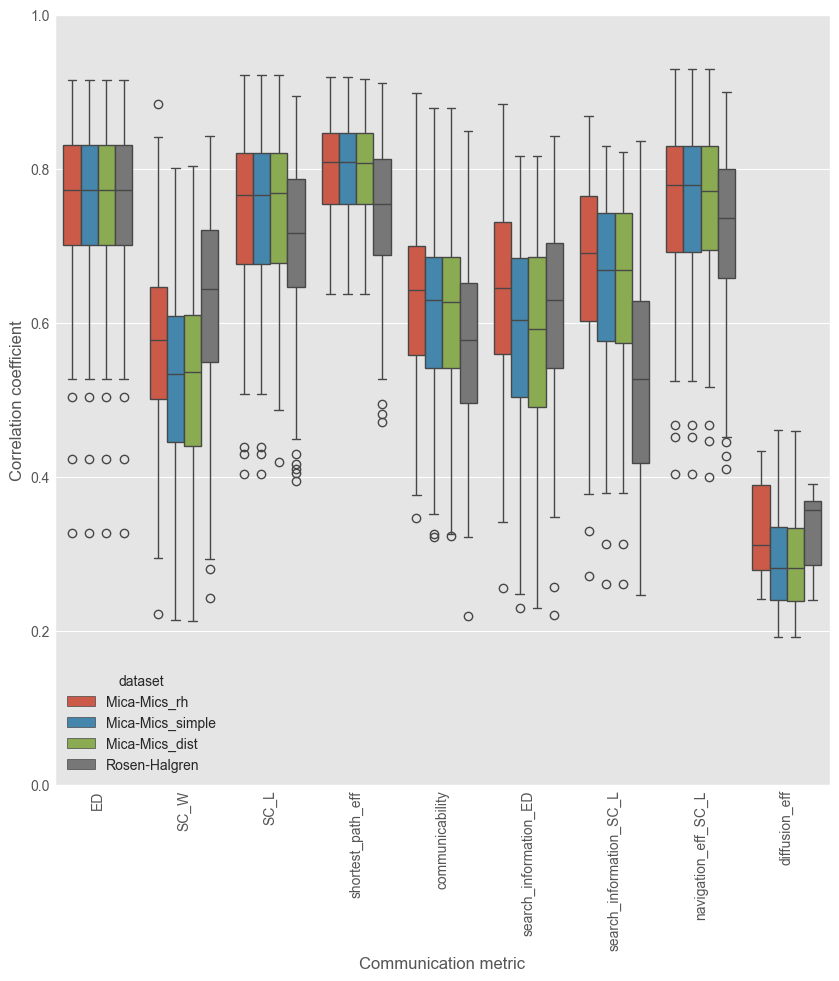

In [92]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=result_p_per_roi, x="Y", y="r_abs_sigf", hue="dataset")
ax.set_ylim(bottom=0, top=1)
ax.tick_params(axis='x', rotation=90)
plt.xlabel('Communication metric')
plt.ylabel('Correlation coefficient')
plt.show()

In [80]:
statistics_per_roi

r  p_sigf_num          n
dataset          Y                                                       
Mica-Mics_dist   ED                      -0.721123         235  39.134100
                 SC_L                    -0.716762         232  36.467433
                 SC_W                     0.500805         190  39.134100
                 communicability          0.571475         206  39.134100
                 diffusion_eff           -0.055567          30  39.134100
                 navigation_eff_SC_L      0.730912         236  39.134100
                 search_information_ED   -0.557027         205  38.567050
                 search_information_SC_L -0.601709         211  38.567050
                 shortest_path_eff        0.734866         234  39.134100
Mica-Mics_rh     ED                      -0.721123         235  39.134100
                 SC_L                    -0.723605         236  38.555556
                 SC_W                     0.549176         204  39.134100
                 communicability          0.591169         208  39.134100
                 diffusion_eff            0.057705           9  39.134100
                 navigation_eff_SC_L      0.734326         237  39.134100
                 search_information_ED   -0.608747         213  38.567050
                 search_information_SC_L -0.632736         219  38.567050
                 shortest_path_eff        0.735628         235  39.134100
Mica-Mics_simple ED                      -0.721123         235  39.134100
                 SC_L                    -0.723605         236  38.555556
                 SC_W                     0.503854         192  39.134100
                 communicability          0.571387         205  39.134100
                 diffusion_eff           -0.056019          30  39.134100
                 navigation_eff_SC_L      0.734326         237  39.134100
                 search_information_ED   -0.561828         206  38.567050
                 search_information_SC_L -0.602031         211  38.567050
                 shortest_path_eff        0.735628         235  39.134100
Rosen-Halgren    ED                      -0.721123         235  39.134100
                 SC_L                    -0.649904         223  38.567050
                 SC_W                     0.554636         204  39.134100
                 communicability          0.511444         196  39.134100
                 diffusion_eff            0.057341          12  39.134100
                 navigation_eff_SC_L      0.663111         226  39.134100
                 search_information_ED   -0.537479         196  38.567050
                 search_information_SC_L -0.484517         188  38.567050
                 shortest_path_eff        0.677782         228  39.134100